# Introduction
This notebook is intended to showcase a text classification proof-of-concept model, developed in TensorFlow.

The dataset used for this notebook is the [Cornell Movie Review dataset](http://www.cs.cornell.edu/people/pabo/movie-review-data/).

# Data Exploration and Analysis
First, let's load our dataset into a `pandas` dataframe.

In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv("./data/cornell_movie_review.csv", index_col=0)

Let's get an idea of what the dataset looks like here.

In [3]:
df.head()

,label,review
id,,
1,pos,films adapted from comic books have had plenty...
2,pos,every now and then a movie comes along from a ...
3,pos,you've got mail works alot better than it dese...
4,pos,""" jaws "" is a rare film that grabs your atten..."
5,pos,moviemaking is a lot like being the general ma...


Hmm, it looks like **review** can't fully fit in the above table.  
Let's grab the first review (1-indexed!) and see what it looks like:

In [4]:
df['review'][1]

'films adapted from comic books have had plenty of success , whether they\'re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there\'s never really been a comic book like from hell before .  for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid \'80s with a 12-part series called the watchmen .  to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd .  the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes .  in other words , don\'t dismiss this film because of its source .  if you can get past the whole comic book thing , you might find another stumbling block in from hell\'s directors , albert and allen hughes .  getting the hughes brothers to direct this seems almo

Wow, that's a lengthy review.  
Let's check how many reviews there are in the dataset:

In [5]:
len(df)

2000

The [Cornell Movie Review dataset](http://www.cs.cornell.edu/people/pabo/movie-review-data/) is divided into positive and negative reviews.  
Let's check how many positive, and how many negative, reviews there are in this dataset:

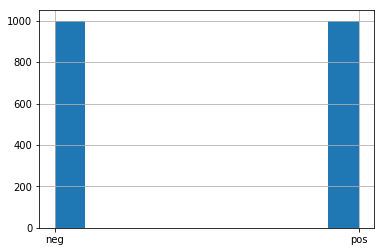

In [6]:
df['label'].hist()

Excellent, the dataset is already balanced.  
Having a balanced dataset makes it easier to train a deep learning model, because it's less likely that the model will focus on one of the classes, and ignore the other.

Now, let's see what the distribution of review lengths is, in numbers of characters:

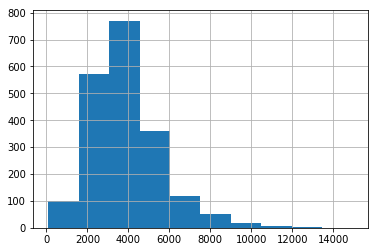

In [7]:
df['review'].apply(len).hist()

Ok, there are some much longer reviews in this dataset than the ~4,000 character review above, but most of them are under 6,000 characters.

# Data Preprocessing
The problem we are trying to solve here is called **sentiment analysis**, that is, whether the given text is positive or negative.

More broadly, this is a type of machine learning problem known as classification.

There are numerous different ways to think about the above dataset.  
We can think of it as a collection of characters, a sequence of characters, a collection of words, or a sequence of words.  
It turns out that the sequence-of-words approach has gotten good results on sentiment analysis problems, so let's think about the above dataset in those terms.

Let's consider another review in the dataset:

In [8]:
df['review'][5]

'moviemaking is a lot like being the general manager of an nfl team in the post-salary cap era -- you\'ve got to know how to allocate your resources .  every dollar spent on a free-agent defensive tackle is one less dollar than you can spend on linebackers or safeties or centers .  in the nfl , this leads to teams like the detroit lions , who boast a superstar running back with a huge contract , but can only field five guys named herb to block for him .  in the movies , you end up with films like " spawn " , with a huge special-effects budget but not enough money to hire any recognizable actors .  jackie chan is the barry sanders of moviemaking .  he spins and darts across the screen like sanders cutting back through the defensive line .  watching jackie in operation condor as he drives his motorcycle through the crowded streets of madrid , fleeing an armada of pursuers in identical black compact cars , is reminiscent of sanders running for daylight with the chicago bears in hot pursui

## Tokenization
What we would like to do is to turn the text above into a fixed-length sequence of numbers, which is what our TensorFlow model will expect in order to train on.

The basic idea behind working with text data is that we want to create a number for each unique "token" that we see, then we can just substitute a "token"'s number for the token itself, and arrive at a fixed-length sequence of numbers for TensorFlow to work with.

As can be seen above, it's not just words that are present, but also punctuation.  

Thankfully, the [natural language toolkit](http://www.nltk.org/) is excellent at turning a string of text into a list of tokens.

Let's see how it behaves on the above review:

In [9]:
import nltk

In [10]:
nltk.tokenize.word_tokenize(df['review'][5])

['moviemaking',
 'is',
 'a',
 'lot',
 'like',
 'being',
 'the',
 'general',
 'manager',
 'of',
 'an',
 'nfl',
 'team',
 'in',
 'the',
 'post-salary',
 'cap',
 'era',
 '--',
 'you',
 "'ve",
 'got',
 'to',
 'know',
 'how',
 'to',
 'allocate',
 'your',
 'resources',
 '.',
 'every',
 'dollar',
 'spent',
 'on',
 'a',
 'free-agent',
 'defensive',
 'tackle',
 'is',
 'one',
 'less',
 'dollar',
 'than',
 'you',
 'can',
 'spend',
 'on',
 'linebackers',
 'or',
 'safeties',
 'or',
 'centers',
 '.',
 'in',
 'the',
 'nfl',
 ',',
 'this',
 'leads',
 'to',
 'teams',
 'like',
 'the',
 'detroit',
 'lions',
 ',',
 'who',
 'boast',
 'a',
 'superstar',
 'running',
 'back',
 'with',
 'a',
 'huge',
 'contract',
 ',',
 'but',
 'can',
 'only',
 'field',
 'five',
 'guys',
 'named',
 'herb',
 'to',
 'block',
 'for',
 'him',
 '.',
 'in',
 'the',
 'movies',
 ',',
 'you',
 'end',
 'up',
 'with',
 'films',
 'like',
 '``',
 'spawn',
 '``',
 ',',
 'with',
 'a',
 'huge',
 'special-effects',
 'budget',
 'but',
 'not',
 

The above is perfectly sufficient tokenization for our purposes.  
Perhaps it could be improved upon slightly, but this breaks up our review into enough unique tokens that our model will be able to learn which ones to use and which ones to discount (more on that in the [Architecture](#Model-Architecture) section)

Now, let's create a set of all the words in all of the reviews in our dataset.  
We will use this set to create a lookup table of tokens to their "IDs".

In [11]:
review_word_set = set()
for r in df['review']:
    review_word_set.update(nltk.tokenize.word_tokenize(r))

In [12]:
len(review_word_set)

46716

Excellent, in our 2,000-review dataset, only some ~47,000 unique "tokens" have been used.  
## Token Encoding
Now, let's use this set to assign IDs to our tokens, so that we can easily go from a token to its ID, and vice versa.

First though, let's reserve ID `0` for reasons that will become clear in the [Padding](#Padding) section below, and start at ID `1`.

In [13]:
word_to_id = {word: i for i, word in enumerate(review_word_set, 1)}

In [14]:
word_to_id

{'he': 1,
 'lodger': 2,
 "'til": 3,
 'lechter': 4,
 'gunned': 5,
 'lensing': 6,
 'seemed': 7,
 'livelier': 8,
 'nanobombs': 9,
 'still-alive': 10,
 "'vanity": 11,
 'dish': 12,
 'marie-therese': 13,
 'rudolph-': 14,
 'risks': 15,
 'clause': 16,
 'deleting': 17,
 'high-gadget': 18,
 'jacobi': 19,
 'retina': 20,
 'oh-so-fabulous': 21,
 'pours': 22,
 'uberman': 23,
 'hammering': 24,
 'legally': 25,
 'shopgirl': 26,
 'quayle-ish': 27,
 'rainier': 28,
 'fingal': 29,
 'dalai': 30,
 'idealist': 31,
 'gays': 32,
 'episodic': 33,
 'crackled': 34,
 'arcade': 35,
 'alive': 36,
 'unmarried': 37,
 'preceeding': 38,
 'tortured': 39,
 'mcdonough': 40,
 'pouring': 41,
 'brilliantly': 42,
 'plant': 43,
 'capitalizes': 44,
 'nails-tough': 45,
 'beloveds': 46,
 'mandated': 47,
 'flight': 48,
 "'suggested": 49,
 'rizzo': 50,
 'disuse': 51,
 'inspector': 52,
 'presents': 53,
 'scouts': 54,
 'politically-charged': 55,
 'lawford': 56,
 'beacon': 57,
 'directors': 58,
 'quick': 59,
 'netted': 60,
 'restart': 6

Excellent, we're much closer to being able to having our dataset in a form that TensorFlow can work with.  
Just for sanity, let's see what the review above would look like as a list of the IDs above:

In [15]:
[word_to_id[word] for word in nltk.tokenize.word_tokenize(df['review'][5])]

[32221,
 10302,
 5106,
 36217,
 2051,
 33484,
 23669,
 20808,
 42013,
 11339,
 31236,
 32516,
 42752,
 7613,
 23669,
 21618,
 24858,
 10064,
 37277,
 13490,
 42901,
 7912,
 2039,
 42037,
 10722,
 2039,
 14249,
 42485,
 46517,
 28367,
 19767,
 29352,
 29044,
 38111,
 5106,
 8294,
 40175,
 38914,
 10302,
 18085,
 5251,
 29352,
 26119,
 13490,
 38841,
 9452,
 38111,
 4030,
 18016,
 30079,
 18016,
 13229,
 28367,
 7613,
 23669,
 32516,
 14600,
 23181,
 38540,
 2039,
 18537,
 2051,
 23669,
 24373,
 4171,
 14600,
 5877,
 44388,
 5106,
 4119,
 8571,
 28855,
 139,
 5106,
 25736,
 8332,
 14600,
 43042,
 38841,
 5648,
 28663,
 22882,
 12705,
 6257,
 15750,
 2039,
 13113,
 43946,
 36632,
 28367,
 7613,
 23669,
 8651,
 14600,
 13490,
 22612,
 35411,
 139,
 8686,
 2051,
 35447,
 25889,
 35447,
 14600,
 139,
 5106,
 25736,
 39290,
 39408,
 43042,
 1774,
 12457,
 33880,
 2039,
 36852,
 7350,
 11026,
 27722,
 28367,
 40733,
 31306,
 10302,
 23669,
 25371,
 38682,
 11339,
 32221,
 28367,
 1,
 30073,
 1

I'm going to trust that the above is mostly correct, but let's at least check that `moviemaking` is index `30643`, as above:

In [16]:
word_to_id["moviemaking"]

32221

Perfect.  Now, let's convert all of the tokenized reviews into lists of `ID`s

In [17]:
reviews_as_ids = []
for review in df['review']:
    reviews_as_ids.append([word_to_id[word] for word in nltk.tokenize.word_tokenize(review)])

Again, as a sanity check, the 5th item in the `reviews_as_ids` list should be the same as the list that we see two cells above:

In [18]:
reviews_as_ids[4]

[32221,
 10302,
 5106,
 36217,
 2051,
 33484,
 23669,
 20808,
 42013,
 11339,
 31236,
 32516,
 42752,
 7613,
 23669,
 21618,
 24858,
 10064,
 37277,
 13490,
 42901,
 7912,
 2039,
 42037,
 10722,
 2039,
 14249,
 42485,
 46517,
 28367,
 19767,
 29352,
 29044,
 38111,
 5106,
 8294,
 40175,
 38914,
 10302,
 18085,
 5251,
 29352,
 26119,
 13490,
 38841,
 9452,
 38111,
 4030,
 18016,
 30079,
 18016,
 13229,
 28367,
 7613,
 23669,
 32516,
 14600,
 23181,
 38540,
 2039,
 18537,
 2051,
 23669,
 24373,
 4171,
 14600,
 5877,
 44388,
 5106,
 4119,
 8571,
 28855,
 139,
 5106,
 25736,
 8332,
 14600,
 43042,
 38841,
 5648,
 28663,
 22882,
 12705,
 6257,
 15750,
 2039,
 13113,
 43946,
 36632,
 28367,
 7613,
 23669,
 8651,
 14600,
 13490,
 22612,
 35411,
 139,
 8686,
 2051,
 35447,
 25889,
 35447,
 14600,
 139,
 5106,
 25736,
 39290,
 39408,
 43042,
 1774,
 12457,
 33880,
 2039,
 36852,
 7350,
 11026,
 27722,
 28367,
 40733,
 31306,
 10302,
 23669,
 25371,
 38682,
 11339,
 32221,
 28367,
 1,
 30073,
 1

Excellent, we have now transformed our dataset of movie reviews into a list of integers.  

## Label Encoding
Now, let's generate an array that we can use with TensorFlow from the labels in the dataset.

In [19]:
import numpy as np

In [20]:
df.head()

,label,review
id,,
1,pos,films adapted from comic books have had plenty...
2,pos,every now and then a movie comes along from a ...
3,pos,you've got mail works alot better than it dese...
4,pos,""" jaws "" is a rare film that grabs your atten..."
5,pos,moviemaking is a lot like being the general ma...


In [21]:
df.tail()

,label,review
id,,
1996,neg,"if anything , "" stigmata "" should be taken as ..."
1997,neg,"john boorman's "" zardoz "" is a goofy cinematic..."
1998,neg,the kids in the hall are an acquired taste . ...
1999,neg,there was a time when john carpenter was a gre...
2000,neg,two party guys bob their heads to haddaway's d...


We have a list of the reviews which have been integer-tokenized, now let's generate a parallel list of whether the review is positive or negative.

In [22]:
review_labels = np.array(df['label'] == 'pos', dtype=int)

In [23]:
review_labels[:5]

array([1, 1, 1, 1, 1])

In [24]:
review_labels[-5:]

array([0, 0, 0, 0, 0])

As a sanity check, the length of this numpy array should be `2000`.

In [25]:
len(review_labels)

2000

## Padding
The reviews in our dataset contain a different length of tokens.

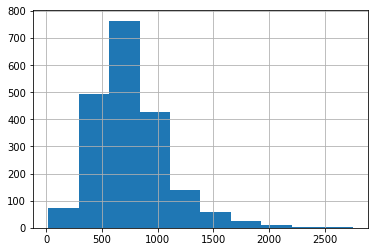

In [26]:
pd.Series(reviews_as_ids).apply(len).hist()

Most of our reviews are under ~1,200 tokens long, and a few are over 2,500 tokens.

The problem is that TensorFlow accepts only inputs of fixed length.  
Further, LSTMs often have a practical limitation of only working with sequences that are a few hundred items long.

This requires us to pick **a single token length** for our reviews as inputs.  
Reviews which are shorter than this will be padded on the **right** with `0`s, and reviews which are longer will have to be truncated before being fed to TensorFlow.

This is not as serious a limitation as it sounds, but it does have to be dealt with, or TensorFlow will throw errors during training.

In [27]:
seq_len = 200
x = np.zeros((len(reviews_as_ids), seq_len), dtype=int)
for i, review_as_id in enumerate(reviews_as_ids):
    x[i, :len(review_as_id)] = np.array(review_as_id)[:seq_len]

Shown below are two such sequences, one originally longer than 200 tokens, and one shorter.

In [28]:
x[1], x[47]

(array([19767, 31382, 15988, 11430,  5106, 17209, 12329, 27333, 35526,
         5106,  9738, 26691, 14600,   139, 19767, 28659, 18254, 14001,
        11076,  4319,  5106,   929, 14600, 15988,  2039, 46197, 15337,
         3446, 15661, 26028, 33893, 23669, 26691, 17947, 23669, 36559,
        11102,  5106, 43407, 22742, 28367,  9069,  8686,  4311, 13401,
        14600,  5106, 20575, 20697,  7395,  3948, 44166, 44145, 15988,
        32906, 16884, 14600, 10302,  5106, 10381, 37820, 28367, 35222,
        39598, 42037, 23181, 36559, 46015,  5106, 23775, 44066, 14001,
        38188, 36460, 23669, 16505, 10302, 37700, 26429, 28367, 12961,
        26990,  7141, 20575, 20697, 10302,  5857, 21369, 45500, 28367,
        29161,  2487, 15661, 32906, 16884, 17947, 10302, 31236, 15260,
          139, 41048, 37666, 17863, 18890,  3454, 19767, 10560, 14600,
        15134, 14600, 15134, 14600, 20575, 28367, 26825, 28367, 35447,
         1756, 35447, 15661, 44166, 44145, 17947, 14600, 40914, 11339,
      

# Data Splitting and Shuffling

Now that we have transformed our dataset into a format that TensorFlow can work with, we need to split the dataset into training, testing, and validation sets, so that we can better evaluate the model's performance.

Let's use numpy to help us randomize here

In [29]:
## Use a seed for reproducibility of results
np.random.seed(42)
permute = np.random.permutation(range(len(x)))

In [30]:
## Generate shuffled versions of our data and labels
x_shuffled = x[permute]
y_shuffled = review_labels[permute]

In [31]:
## Use an 80% : 10% : 10% split into training : testing : validation sets
train_split = int(0.8*len(x))
test_split = int(0.9*len(x))

train_x = x_shuffled[:train_split]
test_x = x_shuffled[train_split:test_split]
val_x = x_shuffled[test_split:]

train_y = y_shuffled[:train_split]
test_y = y_shuffled[train_split:test_split]
val_y = y_shuffled[test_split:]

As a sanity check, recall that the original dataset was 1000 positive reviews followed by 1000 negative reviews.  
If we've truly shuffled, then the beginning of each of the training, testing, and validation sets should be a mixture of positive or negative:

In [32]:
train_y[:6]

array([0, 1, 0, 1, 0, 0])

In [33]:
test_y[:6]

array([1, 1, 0, 1, 1, 0])

In [34]:
val_y[:6]

array([0, 1, 0, 0, 1, 0])

As a final sanity check, note that an 80%, 10%, 10% split should yield numpy arrays of size `1600`, `200`, and `200`

In [35]:
len(train_x), len(test_x), len(val_x)

(1600, 200, 200)

# Checkpointing
We will use this opportunity to save our training, testing, and validation sets to disk, so that we can quickly load them in the future.

In [60]:
np.save("train_x", train_x)
np.save("train_y", train_y)
np.save("test_x", test_x)
np.save("test_y", test_y)
np.save("val_x", val_x)
np.save("val_y", val_y)

In [62]:
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")
test_x = np.load("test_x.npy")
test_y = np.load("test_y.npy")
val_x = np.load("val_x.npy")
val_y = np.load("val_y.npy")

# Model Architecture

## Placeholders
Let's define the necessary placeholders in order for us to feed our pre-processed data from above into a TensorFlow model:

In [36]:
import tensorflow as tf

/home/human/miniconda3/envs/ProofOfConcept/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [37]:
graph = tf.Graph()

In [38]:
with graph.as_default():
    # Define placeholders to accept batches of token-sequences
    inputs = tf.placeholder(tf.int32, [None, None], name = "inputs")
    labels = tf.placeholder(tf.int32, [None, None], name = "labels")
    
    # Define a placeholder to allow us to tweak the dropout hyperparameter
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

## Embedding
Many of the unique tokens that exist in our dataset, and thus have been assigned an `ID`, occur rarely.  
Things that occur rarely don't give a deep learning model much chance to learn what they mean, and so generally they hurt performance unless we take special steps to combat them.

As it turns out, we can probably condense the above ~47,000 unique tokens into as few as 300 tokens, and still have the model perform well.  

This is done through the use of an ["embedding"](https://www.tensorflow.org/versions/master/tutorials/seq2seq#embedding) layer, which lets our model decide which of the tokens it sees are important, and which are just noise.

Thankfully, TensorFlow provides a compact way to define and use embeddings:

In [39]:
embedding_size = 300

with graph.as_default():
    # Define an embedding that allows us to map our ~47,000 review tokens to our embedding size
    # Our model will "learn" a good embedding during training
    embedding = tf.Variable(tf.random_uniform((len(review_word_set) + 1, embedding_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Encoder
Now that we have defined an embedding to squash our input token sequences into a more manageable space, we now define an encoder that will be the heart of this bi-directional stacked LSTM model:

In [40]:
lstm_layers = 2

with graph.as_default():
    
    def getLSTMlist(num_layers):
        """
        Returns a list containing num_layers LSTM cells,
        wrapped in dropout.
        
        This is to avoid TensorFlow syntax errors with the
        [cell] * num_layers construction
        """
        cell_list = []
        for _ in range(num_layers):
            # Your basic LSTM cell
            lstm = tf.contrib.rnn.BasicLSTMCell(num_layers)

            # Add dropout to the cell, using the keep_prob tensor
            drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            cell_list.append(drop)
        return cell_list
    
    forward_LSTMs = getLSTMlist(2)
    backward_LSTMs = getLSTMlist(2)
    
    # Stack up multiple bidirectional LSTM layers
    # Use dynamic to handle the unpacking of non-sequential input (embed)
    outputs, unused_output_state_fw, unused_output_state_bw = \
        tf.contrib.rnn.stack_bidirectional_dynamic_rnn(forward_LSTMs, backward_LSTMs, embed, dtype=tf.float32)

## Loss Function and Optimizer
Finally, we will need to specify a loss function for our model so that it learns properly.

In [41]:
learning_rate = 1e-3

with graph.as_default():
    # Squash outputs to a single integer in the range of 0 to 1
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    
    # 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

## Evaluation Operations

In [42]:
with graph.as_default():

    ## Round our sigmoid [0,1] output to be either 0 or 1
    predictions_integer = tf.cast(tf.round(predictions), tf.int32)

    ## Define operations for {true, false} {positive, negative} predictions
    TP = tf.count_nonzero(predictions_integer * labels, name='True_Positives', dtype=tf.int32)
    TN = tf.count_nonzero((predictions_integer - 1) * (labels - 1), name="True_Negatives", dtype=tf.int32)
    FP = tf.count_nonzero(predictions_integer * (labels - 1), name="False_Positives", dtype=tf.int32)
    FN = tf.count_nonzero((predictions_integer - 1) * labels, name="False_Negatives", dtype=tf.int32)

    ## Define operations for accuracy, precision, recall, and F1 score

    # accuracy ::= (TP + TN) / (TN + FN + TP + FP)
    accuracy = tf.divide(tf.add(TP, TN), tf.add(TN, tf.add(FN, tf.add(TP, FP))), name="Accuracy")

    # precision ::= TP / (TP + FP)
    precision = tf.divide(TP, tf.add(TP, FP), name="Precision")

    # recall::= TP / (TP + FN)
    recall = tf.divide(TP, tf.add(TP, FN), name="Recall")

    # F1 score ::= 2 * precision * recall / (precision + recall)
    f1 = tf.divide((2 * precision * recall), (precision + recall), name="F1_score")

    # To also record this information in TensorBoard, we'll define scalar summaries here
    with tf.name_scope('summaries'):
        tf.summary.scalar('Loss', loss)
        tf.summary.scalar('Accuracy', accuracy)
        tf.summary.scalar('Precision', precision)
        tf.summary.scalar('Recall', recall)
        tf.summary.scalar('F1_score', f1)

# Training the Model
We're almost ready to start training our model.

Before we begin training, let's define a function that we can use to generate batches of our training data, so that we don't risk running out of memory by loading everything into the model at once.

In [43]:
def get_batches(x, y, batch_size=100):
    '''
    Given a set of features x, and a set of labels y,
    return a generator yields batch_size tuples of x and y.
    
    Note that this function truncates x and y, if necessary,
    so that it only returns full batches.
    '''
    num_batches = len(x) // batch_size
    x, y = x[:num_batches * batch_size], y[:num_batches * batch_size]
    for i in range(0, len(x), batch_size):
        yield x[i:i + batch_size], y[i:i + batch_size]

In [56]:
# To keep our summary directories separate
from datetime import datetime

In [59]:
epochs = 10
batch_size = 100

summaries_dir = "./summaries/" + datetime.now().strftime("%Y%m%d%H%M%S")

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(summaries_dir + '/train',
                                          sess.graph)
    test_writer = tf.summary.FileWriter(summaries_dir + '/test')
    val_writer = tf.summary.FileWriter(summaries_dir + '/val')
    
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        
        for i, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs: x,
                    labels: y[:, None],
                    keep_prob: 0.8}
            summary, tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, _ = \
                sess.run([merged, loss, accuracy, precision, recall, f1, optimizer], feed_dict=feed)
            train_writer.add_summary(summary, iteration)
            if iteration%5==0:
                print("Epoch:{: 2d}/{}".format(e, epochs),
                      "Iteration: {: 4d} Training".format(iteration),
                      "loss: {:.3f}".format(tr_loss),
                     "accuracy: {:.3f}".format(tr_acc),
                     "precision: {:.3f}".format(tr_prec),
                     "recall: {:.3f}".format(tr_rec),
                     "f1: {:.3f}".format(tr_f1))

            if iteration%25==0:
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs: x,
                            labels: y[:, None],
                            keep_prob: 1}
                    summary, v_loss, v_acc, v_prec, v_rec, v_f1 = \
                        sess.run([merged, loss, accuracy, precision, recall, f1], feed_dict=feed)
                    val_writer.add_summary(summary, iteration)
                print(" "*24,
                      "Validation loss: {:.3f}".format(v_loss),
                     "accuracy: {:.3f}".format(v_acc),
                     "precision: {:.3f}".format(v_prec),
                     "recall: {:.3f}".format(v_rec),
                     "f1: {:.3f}".format(v_f1))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch: 0/10 Iteration:   5 Training loss: 0.261 accuracy: 0.410 precision: 0.486 recall: 0.293 f1: 0.366
Epoch: 0/10 Iteration:  10 Training loss: 0.246 accuracy: 0.530 precision: 0.500 recall: 0.553 f1: 0.525
Epoch: 0/10 Iteration:  15 Training loss: 0.259 accuracy: 0.390 precision: 0.400 recall: 0.392 f1: 0.396
Epoch: 1/10 Iteration:  20 Training loss: 0.242 accuracy: 0.620 precision: 0.594 recall: 0.760 f1: 0.667
Epoch: 1/10 Iteration:  25 Training loss: 0.242 accuracy: 0.620 precision: 0.661 recall: 0.684 f1: 0.672
                         Validation loss: 0.253 accuracy: 0.470 precision: 0.459 recall: 0.583 f1: 0.514
Epoch: 1/10 Iteration:  30 Training loss: 0.241 accuracy: 0.580 precision: 0.578 recall: 0.712 f1: 0.638
Epoch: 2/10 Iteration:  35 Training loss: 0.232 accuracy: 0.710 precision: 0.662 recall: 0.860 f1: 0.748
Epoch: 2/10 Iteration:  40 Training loss: 0.237 accuracy: 0.610 precision: 0.642 recall: 0.741 f1: 0.688
Epoch: 2/10 Iteration:  45 Training loss: 0.239 accurac

# Evaluating Performance

Visualizations go here